In [17]:
import gtn
from IPython.display import display, Image

In [86]:
def get_all_decomps(word):
  if len(word) == 0:
    return []
  elif len(word) == 1:
    return [word]
  else:
    ret = []
    for i in range(1, len(word)+1):
      # print(word[:i], word[i:])
      head = word[:i]
      tails = get_all_decomps(word[i:])
      if len(tails) == 0:
        ret.append(head)
      else:
        for t in tails:
          # print(head, t, ".")
          ret.append(head+"_"+t)
    return ret

word = "word"
decomps = get_all_decomps(word)
print(decomps)
print(len(decomps) == 2**(len(word)-1))

['w_o_r_d', 'w_o_rd', 'w_or_d', 'w_ord', 'wo_r_d', 'wo_rd', 'wor_d', 'word']
True


In [87]:
tokens = {}
tokens["<eps>"] = 0
token_set = set()
token_set.add(word)
decomps = [d.split("_") for d in decomps]
for d in decomps:
    for t in d:
        token_set.add(t)
for i, t in enumerate(token_set):
    tokens[t] = i+1

print(tokens)

{'<eps>': 0, 'd': 1, 'r': 2, 'or': 3, 'wo': 4, 'rd': 5, 'o': 6, 'w': 7, 'wor': 8, 'word': 9, 'ord': 10}


In [88]:
def make_S_graph(word, tokens):
    decomps = get_all_decomps(word)
    decomps = [d.split("_") for d in decomps]
    
    g = gtn.Graph()
    # 0 is start
    s = 0
    g.add_node(True)
    # 1 is end
    e = 1
    g.add_node(False, True)
    
    # add new node for each arc in d
    dst = 1
    for d in decomps:
        src = 0
        for i, t in enumerate(d):
            if i != len(d) - 1:
                dst += 1
                g.add_node()
                print(src, dst, t)
                g.add_arc(src, dst, tokens[t], tokens["<eps>"])
                src = dst
            else:
                print(src, e, t, word)
                g.add_arc(src, e, tokens[t], tokens[word])
    
    return g

In [89]:
S = make_S_graph(word, tokens)

0 2 w
2 3 o
3 4 r
4 1 d word
0 5 w
5 6 o
6 1 rd word
0 7 w
7 8 or
8 1 d word
0 9 w
9 1 ord word
0 10 wo
10 11 r
11 1 d word
0 12 wo
12 1 rd word
0 13 wor
13 1 d word
0 1 word word


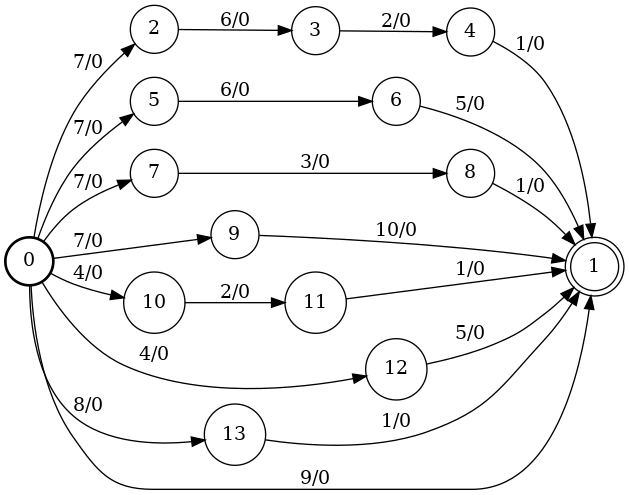

In [90]:
gtn.draw(S, "S_graph.png")
display(Image("S_graph.png"))

In [91]:
gtn.savetxt("S_graph.txt", S)

In [104]:
with open("syms.txt", "w") as f:
    for t in tokens:
        f.write(t + " " + str(tokens[t]) + "\n")
#     f.write("EOF")

In [65]:
# reformat gtn txt to openfst txt
with open("S_graph.txt", "r") as f1, open("S_graph_ofst.txt", "w") as f2:
    lines = f1.readlines()
    end_line = ""
    for i, li in enumerate(lines):
        if i == 0:
            continue
        elif i == 1:
            end_line = li
        else:
            f2.write(li)
    f2.write(end_line)

In [110]:
# !fstcompile --isymbols=syms.txt --osymbols=syms.txt --keep_isymbols --keep_osymbols S_graph.txt S_graph.fst
!fstcompile S_graph.txt S_graph.fst 

In [106]:
!fstprint S_graph.fst

0	2	7	0
0	5	7	0
0	7	7	0
0	9	7	0
0	10	4	0
0	12	4	0
0	13	8	0
0	1	9	9
0
1
2	3	6	0
3	4	2	0
4	1	1	9
5	6	6	0
6	1	5	9
7	8	3	0
8	1	1	9
9	1	10	9
10	11	2	0
11	1	1	9
12	1	5	9
13	1	1	9


In [112]:
!fstdraw --isymbols=syms.txt --osymbols=syms.txt S_graph.fst S_graph.dot
!dot -Tpng S_graph.dot > S_graph.png

In [114]:
!fstdeterminize S_graph.fst S_det.fst
!fstdraw --isymbols=syms.txt --osymbols=syms.txt S_det.fst S_det.dot
!dot -Tpng S_det.dot > S_det.png

In [115]:
!fstminimize S_det.fst S_min.fst
!fstdraw --isymbols=syms.txt --osymbols=syms.txt S_min.fst S_min.dot
!dot -Tpng S_min.dot > S_min.png

In [119]:
!fstprint S_min.fst > S_min.txt

In [123]:
S_min = gtn.loadtxt("S_min.txt")
# need to convert back from openfst form to gtn
# TODO: how to tell which node is start and which is end? Start always 0?

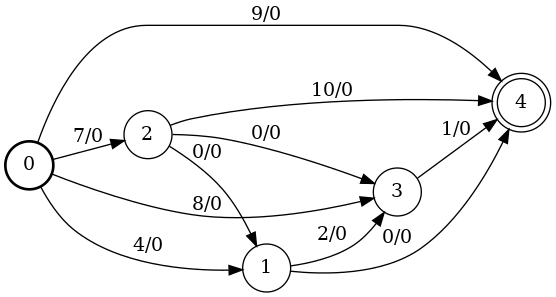

In [124]:
gtn.draw(S_min, "S_min_gtn.png")
display(Image("S_min_gtn.png"))